# Analysis of the gills
- Oleksiy and Flu scanned them
- Dea delineated them
- David does the analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('dark')
from matplotlib_scalebar.scalebar import ScaleBar
import os
import platform
import pandas
import glob
import scipy.misc
import imageio
import scipy.stats
import numpy
import skimage.filters
import skimage.morphology
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Style plots
seaborn.set_style("whitegrid")
seaborn.set_context("paper")

In [3]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
# plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.dpi'] = 300  # Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...
plt.rcParams["savefig.transparent"] = True

In [4]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [6]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [7]:
def percentage(value1, value2):
    """
    We use this over and over in the results part.
    Just a helper function to print out the percentage increase.
    """
    p = value2 / value1
    p -= 1
    p *= 100
    return(p)

In [8]:
def significance(p):
    """See the bottom of https://git.io/vQbWV"""
    if p < 0.0001:
        return "**** (p=%.3f)" % p
    elif (p < 0.001):
        return "*** (p=%.3f)" % p
    elif (p < 0.01):
        return "** (p=%.3f)" % p
    elif (p < 0.05):
        return "* (p=%.3f)" % p
    else:
        return "not significant (p=%.3f)" % p

In [9]:
# Work on the fast SSD from here on!
FastSSD = True
if 'debian' in platform.dist():
    if FastSSD:
        StartDir = '/media/habi/Fast_SSD/'
    else:
        StartDir = '/media/habi/Blue Seagate/'
else:
    if FastSSD:
        StartDir = 'F:/'
    else:
        StartDir = 'G:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [10]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Fast_SSD/Zebra-Fish_Matthias


In [11]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving the output images to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving the output images to /home/habi/P/Documents/Zebrafish-Gills/Output/2ba6016


In [12]:
# Display all plots identically
lines = 5
# And then do something like
# plt.subplot(lines, numpy.ceil(len(ROIFolder) / float(lines)), c + 1)

Let's get going, now that we set up everything...

Get the data from the microCT scans

In [13]:
# Get a list of all the samples we scanned
SampleNames = sorted(next(os.walk(RootFolder))[1])

In [14]:
# Remove Folder we don't want
if not FastSSD:
    SampleNames.remove('Original SEM Bilder')
    SampleNames.remove('tresholding_estimation')

In [15]:
# Save all the information into a pandas dataframe
Data = pandas.DataFrame({'Sample': SampleNames})
Data['Folder'] = [os.path.join(RootFolder, s) for s in SampleNames]
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data.Folder]
Data['RecFolder'] = [os.path.join(RootFolder, f, 'rec') for f in Data.Folder]
Data['VOIFolder'] = [os.path.join(RootFolder, f, 'VOI') for f in Data.Folder]
Data['OverviewName'] = [glob.glob(os.path.join(r, '*spr.bmp'))[0] for r in Data.RecFolder]
Data['ReconstructionNames'] = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in Data.RecFolder]
# Try to be a bit clever with loading the VOI slices
# They are saved as either PNG or BMP, and there's also some other stuff in the folder...
Data['VOINames'] = [sorted(glob.glob(os.path.join(r, '*rec*[0123456789].*'))) for r in Data.VOIFolder]

In [16]:
# Make an 'experiment' column, which we use for the box plots below
def whichexperiment(i):
    '''Categorize  into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return 'Swimmer'
    if 'ontrol' in i:
        return 'Control'

In [17]:
Data['Experiment'] = [whichexperiment(name) for name in Data.Folder]

In [18]:
# Color plot based on label (mrt, ctrl or bb)
def color_based_on_experiment(i):
    '''Colorize into 'Swimmer' or 'Control' '''
    if 'ontrol' in i:
        return seaborn.color_palette()[0]
    if 'immer' in i:
        return seaborn.color_palette()[1]

In [19]:
Data['Color'] = [color_based_on_experiment(name) for name in Data.Folder]

In [20]:
# Get Pixel sizes of the scans
# in micrometers
Data['PixelSize'] = [get_pixelsize(logfile) for logfile in Data.LogFile]

In [21]:
# Calculate the voxel volume, which we'll use later on
# Let's use microlitre as unit
Data['VoxelVolume'] = [ps ** 3 *1e-9 for ps in Data.PixelSize]

Load the other data (XLS files from Matthias).

In [22]:
# Load the fish length data
morphologyfile = glob.glob(os.path.join('XLS*', '*morph*.xlsx'))[0]
# Load all the morphology data into its own dataframe
# With a hat tip to https://stackoverflow.com/a/49442625/323100
Morphology = pandas.read_excel(morphologyfile,
                               usecols = 'E:H,K:N',
                               skiprows=3,
                               nrows=27,
                               names=['Length Swimmer Before',
                                      'Weight Swimmer Before',
                                      'Length Control Before',
                                      'Weight Control Before',
                                      'Length Swimmer After',
                                      'Weight Swimmer After',
                                      'Length Control After',
                                      'Weight Control After'])
# Drop unneeded colums and reset the numbering (index)
Morphology.drop([10,11,12,13,14,15,16], inplace=True)
Morphology.reset_index(inplace=True, drop=True)
# Add a gender column, so we can filter to it
Morphology['Gender'] = 'Female'
Morphology['Gender'][10:]  = 'Male'

In [23]:
# Load the respirometry data
# Since it's in a 'messy' xls sheet, we cannot do it in one go, but do it in four cells :)
respirometryfile = glob.glob(os.path.join('XLS*', '*', 'Respirometry*.xlsx'))[0]
# Based on https://stackoverflow.com/a/49442625/323100
# Load O2 at start
o2 = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols = 'H')
Data['O2 consumption start'] = pandas.concat([o2], ignore_index=True)

In [24]:
# Load O2 at start, normalized
o2_norm = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols = 'I')
# Unfortunately, Matthias saved some more stuff into this colum, so we just drop some cells
o2_norm.drop([10,21,22], inplace=True)
Data['O2 consumption start normalized'] = pandas.concat([o2_norm], ignore_index=True)

In [25]:
# Load O2 at the end
o2_end = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols = 'P')
Data['O2 consumption end'] = pandas.concat([o2_end], ignore_index=True)

In [26]:
# Load O2 at end, normalized
o2_norm_end = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols = 'Q')
# Unfortunately, Matthias saved some more stuff into this colum, so we just drop some cells
o2_norm_end.drop([10,20], inplace=True)
Data['O2 consumption end normalized'] = pandas.concat([o2_norm_end], ignore_index=True)

In [27]:
# Double-check the data
# Data[['Sample',
#       'O2 consumption start', 'O2 consumption start normalized',
#       'O2 consumption end', 'O2 consumption end normalized']]

In [28]:
# Load the SEM data
semfile = glob.glob(os.path.join('XLS*', '*', '*electron*.xlsx'))[0]
# Load filament count
# We could probably do it in one go as above, but then 'squeeze' doesn't seem to discard the empty lines...
Filaments = pandas.DataFrame()
Filaments['Swimmer Count'] = pandas.read_excel(semfile, usecols = 'G', nrows=199, squeeze=True)
Filaments['Control Count'] = pandas.read_excel(semfile, usecols = 'AA', nrows=199, squeeze=True, na_values='Keine Daten')
# Load filament length
Filaments['Swimmer Length'] = pandas.read_excel(semfile, usecols = 'Q', nrows=199, squeeze=True)
Filaments['Control Length'] = pandas.read_excel(semfile, usecols = 'AK', nrows=199, squeeze=True, na_values='Keine Daten')
# Scale from Fiji measurement units to um
Filaments['Swimmer Length'] *= 1 / 0.6 * 100
Filaments['Control Length'] *= 1 / 0.6 * 100

In [29]:
# Load the speed assessment data
speedfile = glob.glob(os.path.join('XLS*', '*speed*.xlsx'))[0]
parser = lambda time: pandas.datetime.strptime(str(time), '%M:%S:00')
Speed = pandas.read_excel(speedfile,
                          usecols = 'B,E,O,R,U',
                          skiprows=3,
                          nrows=29,                         
                          names=['Swimmer Before',
                                 'Control Before',
                                 'Swimmer 3wk',
                                 'Swimmer After',
                                 'Control After'])
# Drop unneeded colums and reset the numbering (index)
Speed.drop([10,11,12,13,14,15,16,17,18], inplace=True)
Speed.reset_index(inplace=True, drop=True)
# Convert the weird Excel time to something we can actually use...
# Pandas parses the M:S Matthias entered as H:M:00
# It would probably easy to do this via a parser, but just converting it with a Timedelta is quicker
# (Which just means I gave up after putting keywords into a search engine for two hours
Speed['Swimmer Before'] = [pandas.Timedelta(minutes=time.hour,seconds=time.minute) for time in Speed['Swimmer Before']]
Speed['Control Before'] = [pandas.Timedelta(minutes=time.hour,seconds=time.minute) for time in Speed['Control Before']]
# Since we have NaN (as float) in the column (data for fish 10 is missing)
# we have to jump through this super-complicated hoop to covert the time to timedelta
# with a tip to the hat to https://stackoverflow.com/a/25142407/323100
Speed['Swimmer 3wk'] = [pandas.Timedelta(minutes=time.hour, seconds=time.minute)
                        if not pandas.isnull(time) else pandas.to_datetime('13000101', format='%Y%m%d', errors='coerce')
                        for time in Speed['Swimmer 3wk']]
Speed['Swimmer After'] = [pandas.Timedelta(minutes=time.hour, seconds=time.minute)
                        if not pandas.isnull(time) else pandas.to_datetime('13000101', format='%Y%m%d', errors='coerce')
                        for time in Speed['Swimmer After']]
Speed['Control After'] = [pandas.Timedelta(minutes=time.hour,seconds=time.minute) for time in Speed['Control After']]
# Add a gender column, so we can filter to it
Speed['Gender'] = 'Female'
Speed['Gender'][10:]  = 'Male'

----

Now that we have all the data we need, we actually read the images in and do our processing to get to the results.

In [30]:
# Load Overviews (not into the dataframe, to keep things speedy)
Overviews = [imageio.imread(o) for o in Data.OverviewName]

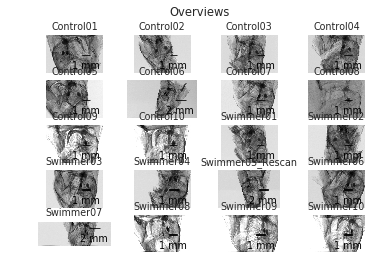

In [31]:
# Display overviews (shadow projections)
for c, o in enumerate(Overviews):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(o)
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um', color='black'))
    plt.axis('off')
    plt.title('%s' % Data.Sample[c])
plt.suptitle('Overviews')
plt.savefig(os.path.join(OutPutDir, 'Overviews.png'))
plt.show()

In [32]:
# Convert *all* VOI slices into single NumPy arrays and save them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below again, we overwrite the variable with NAN and clear the memory
Data['OutputNameVOI'] = [os.path.join(f, sample + '_VOI.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
VOIImages = [numpy.nan for file in Data.OutputNameVOI]
for c, voi in enumerate(Data.OutputNameVOI):
    # Only do this if we didn't do it already...
    if os.path.exists(voi):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1, len(Data.Sample), Data.Sample[c], voi[len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Reading %4s VOI images' % (c + 1, len(Data.Sample), Data.Sample[c], len(Data.VOINames[c])))
        # Actually load the images now
        VOIImages[c] = numpy.array([scipy.misc.imread(i, flatten=True) for i in Data.VOINames[c]])
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%23s: Saving to %s' % (Data.Sample[c], voi))
        numpy.save(voi, VOIImages[c], allow_pickle=False)
        # Clear memory
        VOIImages[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_VOI.npy
 2/20:        Control02: Already saved to /Control02/Control02_VOI.npy
 3/20:        Control03: Already saved to /Control03/Control03_VOI.npy
 4/20:        Control04: Already saved to /Control04/Control04_VOI.npy
 5/20:        Control05: Already saved to /Control05/Control05_VOI.npy
 6/20:        Control06: Already saved to /Control06/Control06_VOI.npy
 7/20:        Control07: Already saved to /Control07/Control07_VOI.npy
 8/20:        Control08: Already saved to /Control08/Control08_VOI.npy
 9/20:        Control09: Already saved to /Control09/Control09_VOI.npy
10/20:        Control10: Already saved to /Control10/Control10_VOI.npy
11/20:        Swimmer01: Already saved to /Swimmer01/Swimmer01_VOI.npy
12/20:        Swimmer02: Already saved to /Swimmer02/Swimmer02_VOI.npy
13/20:        Swimmer03: Already saved to /Swimmer03/Swimmer03_VOI.npy
14/20:        Swimmer04: Already saved to /Swimmer04/Swimmer04_VOI.npy
15/20:

In [33]:
# Free the memory of the images we loaded.
# We 'memory-map' them again below
%xdel VOIImages

In [34]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
VOIImages = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]

In [35]:
# Get ourselves the middle slice to show
Data['MiddleSliceName'] = [n[len(n) // 2] for n in Data.VOINames]
Data['MiddleSlice'] = [i[len(i) // 2] for i in VOIImages]

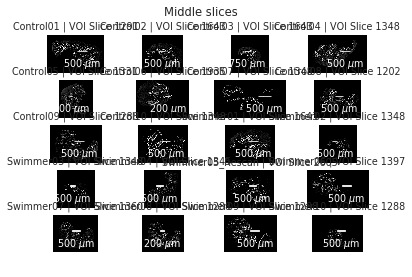

In [36]:
# Display the middle slice of the VOI
for c, m in enumerate(Data.MiddleSlice):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(m, vmax=0.618 * numpy.max(m))
    plt.title('%s | VOI Slice %s' % (Data.Sample[c], os.path.basename(Data.MiddleSliceName[c])[-8:-4]))
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.axis('off')
plt.suptitle('Middle slices')
plt.savefig(os.path.join(OutPutDir, 'MiddleSlices.png'))
plt.show()

In [37]:
Data['NumberOfVOISlices'] = [len(v) for v in Data.VOINames]

In [38]:
# Get the shape of the VOI
Data['VOIShape'] = [voi.shape for voi in VOIImages]
Data['VOIVolume'] = [shape[0] * shape[1] * shape[2] for shape in Data.VOIShape]

In [39]:
# Check of VOI size and number of files is consistent.
for i in range(20):
    if len(Data.VOINames[i]) != len(VOIImages[i]):
        print(Data.Sample[i])
        print(len(Data.VOINames[i]))
        print(Data.VOIShape[i][0])
        print(len(VOIImages[i]))
        print(80 * '-')

In [40]:
# For bragging reasons in the manuscript
# All VOIs
# Data[['Sample', 'VOIVolume', 'VOIShape']].sort_values('VOIVolume', ascending=True)

In [41]:
# Average volume
print('The average volume is a cube of %s pixels' % int(round(Data.VOIVolume.mean() ** (1 / 3.))))

The average volume is a cube of 1938 pixels


In [42]:
# The smallest VOIs
Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape']].sort_values('VOIVolume', ascending=True).head(1)

,Sample,VOIVolume,NumberOfVOISlices,VOIShape
6,Control07,3765644288,2452,"(2452, 896, 1714)"


In [43]:
# For bragging reasons in the manuscript
# The largest VOIs
Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape']].sort_values('VOIVolume', ascending=True).tail(1)

,Sample,VOIVolume,NumberOfVOISlices,VOIShape
2,Control03,19506703712,3062,"(3062, 2524, 2524)"


In [44]:
# Use a manageable amount of equally spaced slices for thresholding and MIP-ing
# NumberOfImagesToShow = 6
# NumberOfImagesToShow = 16
# NumberOfImagesToShow = 111
# NumberOfImagesToShow = 222
# NumberOfImagesToShow = 350
# NumberOfImagesToShow = 1111
NumberOfImagesToShow = Data.NumberOfVOISlices.max()  # just use all of them...

In [45]:
# Generate the subset information
Data['PrintEverySlice'] = [int(round(len(r) / NumberOfImagesToShow)) for r in Data.VOINames]
Data['SubsetNames'] = [rn[::sw] for rn, sw in zip(Data.VOINames, Data.PrintEverySlice)]
for c, i in enumerate(Data.Sample):
    print('For %s we are working with a subset of %s (%0.1f %% of totally %s) equally '
          'spaced slices' % (i,
                             len(Data.SubsetNames[c]),
                             len(Data.SubsetNames[c]) / len(Data.VOINames[c]) * 100,
                             len(Data.VOINames[c])))

For Control01 we are working with a subset of 2338 (100.0 % of totally 2338) equally spaced slices
For Control02 we are working with a subset of 3062 (100.0 % of totally 3062) equally spaced slices
For Control03 we are working with a subset of 3062 (100.0 % of totally 3062) equally spaced slices
For Control04 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control05 we are working with a subset of 2642 (100.0 % of totally 2642) equally spaced slices
For Control06 we are working with a subset of 3389 (100.0 % of totally 3389) equally spaced slices
For Control07 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control08 we are working with a subset of 2400 (100.0 % of totally 2400) equally spaced slices
For Control09 we are working with a subset of 2572 (100.0 % of totally 2572) equally spaced slices
For Control10 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Swimme

In [46]:
# Put len of 'UseThis' into dataframe
Data['NumberOfAnalyzedVOISlices'] = [len((a)) for a in Data.SubsetNames]

In [47]:
# Calculate the thresholds of each slice
Data['OutputNameThreshold'] = [os.path.join(f,
                                            sample + '_thresholds_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
Data['Threshold'] = [[numpy.nan] for s in Data.Sample]
for c, thresholdname in enumerate(Data.OutputNameThreshold):
    if os.path.exists(thresholdname):
        print('%2s/%s: %16s: Grab values from %s' % (c + 1,
                                                     len(Data),
                                                     Data.Sample[c],
                                                     thresholdname[len(RootFolder):]))
        Data['Threshold'][c] = numpy.load(thresholdname)
    else:
        print('%2s/%s: %16s: Calculating thresholds for %s of %4s files' % (c + 1,
                                                                            len(Data), Data.Sample[c],
                                                                            len(Data.VOINames[c][::Data.PrintEverySlice[c]]),
                                                                            len(Data.VOINames[c])))
        Data['Threshold'][c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
        for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
            try:
                # Calculate and save threshold (of only the image, e.g. img[img>0])
                Data['Threshold'][c][d] = skimage.filters.threshold_otsu(image[image > 0])
            except (ValueError):
                # Save NAN if we can't calculate a threshold
                Data['Threshold'][c][d] = numpy.nan
        print('%23s: Saving thresholds to %s' % (Data.Sample[c], thresholdname[len(RootFolder):]))
        numpy.save(thresholdname, Data.Threshold[c], allow_pickle=False)
        Data.Threshold[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Grab values from /Control01/Control01_thresholds_from_2338_of_2338_slices.npy
 2/20:        Control02: Grab values from /Control02/Control02_thresholds_from_3062_of_3062_slices.npy
 3/20:        Control03: Grab values from /Control03/Control03_thresholds_from_3062_of_3062_slices.npy
 4/20:        Control04: Grab values from /Control04/Control04_thresholds_from_2452_of_2452_slices.npy
 5/20:        Control05: Grab values from /Control05/Control05_thresholds_from_2642_of_2642_slices.npy
 6/20:        Control06: Grab values from /Control06/Control06_thresholds_from_3389_of_3389_slices.npy
 7/20:        Control07: Grab values from /Control07/Control07_thresholds_from_2452_of_2452_slices.npy
 8/20:        Control08: Grab values from /Control08/Control08_thresholds_from_2400_of_2400_slices.npy
 9/20:        Control09: Grab values from /Control09/Control09_thresholds_from_2572_of_2572_slices.npy
10/20:        Control10: Grab values from /Control10/Control10_thresholds

In [48]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
Data['Threshold'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThreshold]

In [49]:
# Let's calculate the max, mean and median threshold for each sample
Data['ThresholdMax'] = [numpy.nanmax(t) for t in Data.Threshold]
# Discard the first and last $discard slices
discard = 150
Data['ThresholdAverage'] = [numpy.nanmean(t[discard:-discard]) for t in Data.Threshold]
Data['ThresholdMedian'] = [numpy.nanmedian(t[discard:-discard]) for t in Data.Threshold]

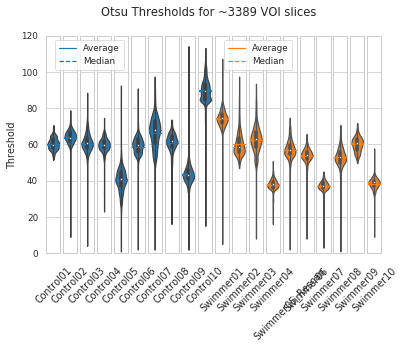

In [50]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(1, len(Data), c + 1)
    seaborn.violinplot(i[discard:-discard], orient='v', color=Data.Color[c], cut=0)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0, Data.ThresholdMax.max()*1.05])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Threshold')
    if '05' in Data.Sample[c]:
        plt.legend()
    plt.xlabel(Data.Sample[c], rotation=45)
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow)
plt.savefig(os.path.join(OutPutDir, 'Thresholds_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

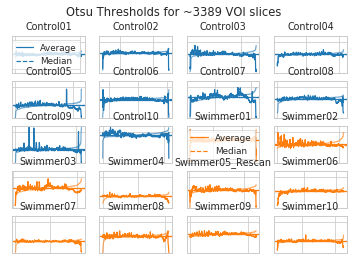

In [51]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.plot(i[discard:-discard], color=Data.Color[c])
    plt.plot(sorted(i[discard:-discard]), color=Data.Color[c], alpha=0.618)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0, Data.ThresholdMax.max()*1.05])
    plt.title(Data.Sample[c])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    if '01' in Data.Sample[c]:
        plt.legend()
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow)
plt.savefig(os.path.join(OutPutDir, 'Thresholds-plot_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [52]:
# Read a subset of images
Data['OutputNameVOISubset'] = [os.path.join(f,
                                            sample + '_VOI_subset_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it to the end :)
VOISubset = [numpy.nan for file in Data.OutputNameVOISubset]
for c, subset in enumerate(Data.OutputNameVOISubset):
    if len(Data.VOINames[c]) != len(Data.VOINames[c][::Data.PrintEverySlice[c]]):
        # We are using a subset
        # Only do this if we didn't do it already...
        if os.path.exists(subset):
            print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                         len(Data.Sample),
                                                         Data.Sample[c],
                                                         subset[len(RootFolder):]))
        else:
            print('%2s/%s: %16s: Subsetting %s of %s VOI images' % (c + 1,
                                                                    len(Data.Sample),
                                                                    Data.Sample[c],
                                                                    len(Data.SubsetNames[c]),
                                                                    len(Data.VOINames[c])))
            VOISubset[c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
            for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
                VOISubset[c][d] = image
            print('%23s: Saving subset to %s' % (Data.Sample[c], subset[len(RootFolder):]))
            numpy.save(subset, VOISubset[c], allow_pickle=False)
            VOISubset[c] = numpy.nan
            gc.collect()
    else:
        # We are using the full dataset
        print('%2s/%s: %16s: Using the full dataset' % (c + 1, len(Data.Sample), Data.Sample[c]))

 1/20:        Control01: Using the full dataset
 2/20:        Control02: Using the full dataset
 3/20:        Control03: Using the full dataset
 4/20:        Control04: Using the full dataset
 5/20:        Control05: Using the full dataset
 6/20:        Control06: Using the full dataset
 7/20:        Control07: Using the full dataset
 8/20:        Control08: Using the full dataset
 9/20:        Control09: Using the full dataset
10/20:        Control10: Using the full dataset
11/20:        Swimmer01: Using the full dataset
12/20:        Swimmer02: Using the full dataset
13/20:        Swimmer03: Using the full dataset
14/20:        Swimmer04: Using the full dataset
15/20: Swimmer05_Rescan: Using the full dataset
16/20:        Swimmer06: Using the full dataset
17/20:        Swimmer07: Using the full dataset
18/20:        Swimmer08: Using the full dataset
19/20:        Swimmer09: Using the full dataset
20/20:        Swimmer10: Using the full dataset


In [53]:
# Clear the memory
%xdel VOISubset

In [54]:
# Load (or memory-map) all the files.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [55]:
# Get the longest samplename, https://stackoverflow.com/a/21295630/323100
namelenmax = Data.Sample.str.len().max()

In [56]:
# Actually threshold the images
singlethreshold = True
if singlethreshold:
    Data['OutputNameThresholded'] = [os.path.join(f, 'VOI_thresholded-with-%0.2f.npy' % tm) for f, tm in zip(Data.Folder, Data.ThresholdAverage)]
else:
    Data['OutputNameThresholded'] = [os.path.join(f, 'VOI_thresholded-slicewise.npy') for f in Data.Folder]
Thresholded = [numpy.nan for file in Data.OutputNameThreshold]
for c, sample in Data.iterrows():
    # Only do this if we didn't do it already...
    if os.path.exists(sample.OutputNameThresholded):
        print('%2s/%s: %s: Already saved to %s' % (c + 1,
                                                   len(Data.Sample),
                                                   sample.Sample.rjust(namelenmax),
                                                   os.path.basename(sample.OutputNameThresholded)))
    else:
        print('%2s/%s: %s: Thresholding %3s VOI images' % (c + 1,
                                                           len(Data.Sample),
                                                           sample.Sample.rjust(namelenmax),
                                                           len(sample.VOINames)))
        Thresholded[c] = [None] * len(sample.VOINames)
        for d, image in enumerate(VOISubset[c]):
            if singlethreshold:
                Thresholded[c][d] = image > sample.Threshold[d]
            else:
                Thresholded[c][d] = image > sample.ThresholdAverage
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%s: Saving to %s' % (os.path.basename(sample.Sample.rjust(namelenmax + 7)), sample.OutputNameThresholded))
        numpy.save(sample.OutputNameThresholded, Thresholded[c], allow_pickle=False)
        Thresholded[c] = numpy.nan
        gc.collect()
if singlethreshold:
    print('\n\nWe were using a single threshold (ThresholdAverage) for *all* the images')
else:
    print('\n\nWe were using the Otsu threshold from each single image')

 1/20:        Control01: Already saved to VOI_thresholded-with-60.33.npy
 2/20:        Control02: Already saved to VOI_thresholded-with-63.97.npy
 3/20:        Control03: Already saved to VOI_thresholded-with-60.43.npy
 4/20:        Control04: Already saved to VOI_thresholded-with-59.55.npy
 5/20:        Control05: Already saved to VOI_thresholded-with-40.26.npy
 6/20:        Control06: Already saved to VOI_thresholded-with-58.81.npy
 7/20:        Control07: Already saved to VOI_thresholded-with-66.36.npy
 8/20:        Control08: Already saved to VOI_thresholded-with-60.89.npy
 9/20:        Control09: Already saved to VOI_thresholded-with-43.90.npy
10/20:        Control10: Already saved to VOI_thresholded-with-89.89.npy
11/20:        Swimmer01: Already saved to VOI_thresholded-with-74.24.npy
12/20:        Swimmer02: Already saved to VOI_thresholded-with-60.36.npy
13/20:        Swimmer03: Already saved to VOI_thresholded-with-62.66.npy
14/20:        Swimmer04: Already saved to VOI_thres

In [57]:
Thresholded = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThresholded]

In [58]:
# # Display middle slices and thresholded equivalent
# for c, fish in Data.iterrows():
#     plt.subplot(121)
#     plt.imshow(VOIImages[c][len(VOIImages[c]) // 2])
#     plt.title('%s: Middle slice (...%s)' % (fish.Sample, Data.VOINames[c][len(VOIImages[c]) // 2][-12:]))
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.subplot(122)
#     plt.imshow(Thresholded[c][len(Thresholded[c]) // 2])
#     plt.title('Thresholded with %0.2f' % Data.ThresholdAverage[c])
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.savefig(os.path.join(OutPutDir, 'MiddleSlices.%s.png' % fish.Sample))
#     plt.show()

In [59]:
# Save thresholded images out
SaveImages = True
if SaveImages:
    # Save thresholded images
    for c, folder in enumerate(Data.VOIFolder):
        CurrentOutputFolder = os.path.join(folder, os.path.splitext(os.path.basename(Data.OutputNameThresholded[c]))[0])
        if not os.path.exists(CurrentOutputFolder):
            os.makedirs(CurrentOutputFolder)
        if len(glob.glob(os.path.join(CurrentOutputFolder, '*.png'))) >= len(VOIImages[c]):
            print('%2s/%s: %s: Already saved %s thresholded images to %s' % (c + 1,
                                                                             len(Data),
                                                                             Data.Sample[c].rjust(namelenmax),
                                                                             len(VOIImages[c]),
                                                                             CurrentOutputFolder[len(RootFolder) + 1:]))
        else:
            print('%2s/%s: %s: Saving %s thresholded images to %s' % (c + 1,
                                                                      len(Data),
                                                                      Data.Sample[c].rjust(namelenmax),
                                                                      len(Thresholded[c]),
                                                                      CurrentOutputFolder[len(RootFolder) + 1:]))
            for d, i in enumerate(Thresholded[c]):
                scipy.misc.imsave(os.path.join(CurrentOutputFolder,
                                               Data.Sample[c] + '_thresholded_%04d.png' % d), i.astype('uint8') * 255)

 1/20:        Control01: Already saved 2338 thresholded images to Control01/VOI/VOI_thresholded-with-60.33
 2/20:        Control02: Already saved 3062 thresholded images to Control02/VOI/VOI_thresholded-with-63.97
 3/20:        Control03: Already saved 3062 thresholded images to Control03/VOI/VOI_thresholded-with-60.43
 4/20:        Control04: Already saved 2452 thresholded images to Control04/VOI/VOI_thresholded-with-59.55
 5/20:        Control05: Already saved 2642 thresholded images to Control05/VOI/VOI_thresholded-with-40.26
 6/20:        Control06: Already saved 3389 thresholded images to Control06/VOI/VOI_thresholded-with-58.81
 7/20:        Control07: Already saved 2452 thresholded images to Control07/VOI/VOI_thresholded-with-66.36
 8/20:        Control08: Already saved 2400 thresholded images to Control08/VOI/VOI_thresholded-with-60.89
 9/20:        Control09: Already saved 2572 thresholded images to Control09/VOI/VOI_thresholded-with-43.90
10/20:        Control10: Already save

In [60]:
# # Display some original slices through the VOIs
# SlicesToShow = 5
# Iterator = [int(round(len(r) / SlicesToShow)) for r in Data.VOINames]
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(VOIImages[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_originals.png' % (sample.Sample, SlicesToShow)))
#     plt.show()

In [61]:
# # Display some thresholded slices through the VOIs
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(Thresholded[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_thresholded.png' % (sample.Sample, SlicesToShow)))
#     plt.show()

In [62]:
# Read or generate the MIPs
Data['OutputNameMIP'] = [os.path.join(f,
                                      sample + '_MIP_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                      len(n)))
                         for f, sample, n, p in zip(Data.Folder,
                                                    Data.Sample,
                                                    Data.VOINames,
                                                    Data.PrintEverySlice)]
MIPs = [None] * len(Data)
for c, fn in enumerate(Data.OutputNameMIP):
    if os.path.exists(fn):
        print('%2s/%s: %16s: Loading %s into memory' % (c + 1,
                                                        len(Data),
                                                        Data.Sample[c],
                                                        fn[len(RootFolder):]))
        MIPs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%2s/%s: %16s: Generating MIP from %s images' % (c + 1,
                                                               len(Data),
                                                               Data.Sample[c],
                                                               len(Data.SubsetNames[c])))
        MIPs[c] = numpy.max(VOISubset[c], axis=0)
        numpy.save(fn, MIPs[c], allow_pickle=False)
        # Free up memory
        VOISubset[c]._mmap.close()
        gc.collect()
    # Save MIP to PNG image
    scipy.misc.imsave(os.path.splitext(fn)[0] + '.png', MIPs[c])

 1/20:        Control01: Loading /Control01/Control01_MIP_from_2338_of_2338_slices.npy into memory
 2/20:        Control02: Loading /Control02/Control02_MIP_from_3062_of_3062_slices.npy into memory
 3/20:        Control03: Loading /Control03/Control03_MIP_from_3062_of_3062_slices.npy into memory
 4/20:        Control04: Loading /Control04/Control04_MIP_from_2452_of_2452_slices.npy into memory
 5/20:        Control05: Loading /Control05/Control05_MIP_from_2642_of_2642_slices.npy into memory
 6/20:        Control06: Loading /Control06/Control06_MIP_from_3389_of_3389_slices.npy into memory
 7/20:        Control07: Loading /Control07/Control07_MIP_from_2452_of_2452_slices.npy into memory
 8/20:        Control08: Loading /Control08/Control08_MIP_from_2400_of_2400_slices.npy into memory
 9/20:        Control09: Loading /Control09/Control09_MIP_from_2572_of_2572_slices.npy into memory
10/20:        Control10: Loading /Control10/Control10_MIP_from_2452_of_2452_slices.npy into memory
11/20:    

In [63]:
# # Display x,y,z-MIPs
# for c, sample in enumerate(VOISubset):
#     plt.imshow(numpy.max(sample, axis=1))
#     plt.title(Data.Sample[c])
#     plt.show()

In [64]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

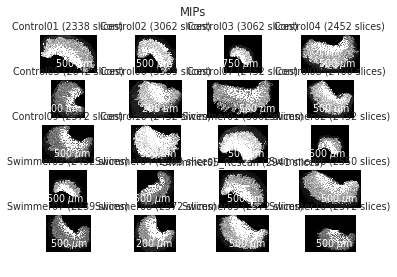

In [65]:
# Display 'through-the-sample' MIPs
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.imshow(m)
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.title('%s (%s slices)' % (SampleNames[c], len(Data.SubsetNames[c])))
    plt.axis('off')
plt.suptitle('MIPs')
plt.savefig(os.path.join(OutPutDir, 'MIPs_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [66]:
# grab the thresholds in the 60-80% range of the respective values
split = 5
Selected = [sorted(t)[(split - 2) * len(t) // split:(split - 1) * len(t) // split] for t in Data.Threshold]
# mask the values of the threshold that are *not* in this range
Otsu_selected = [numpy.ma.masked_outside(o, numpy.min(sel), numpy.max(sel)) for o, sel in zip(Data.Threshold, Selected)]
# use the mean of this 60-80% value to threshold the datasets
Data['Threshold6080'] = [numpy.nanmean(os) for os in Otsu_selected]

In [67]:
# # Display the different thresholds
# for c, s in enumerate(SampleNames):
#     plt.plot(Data.Threshold[c], marker='', label='%s | Global Otsu Mean=%.2f | 60-80%% Otsu mean=%0.2f' % (s,
#                                                                                                            Data.ThresholdAverage[c],
#                                                                                                            Data.Threshold6080[c]),
#              c=seaborn.color_palette(n_colors=len(SampleNames))[c])
#     plt.plot(Otsu_selected[c], '.', ms=25, alpha=0.618, markeredgecolor='k', markeredgewidth=1,
#              c=seaborn.color_palette(n_colors=len(Data))[c])
#     plt.legend(loc='best')
# plt.xlim([0, Data.NumberOfVOISlices.max()])
# plt.title('Otsu thresholds for each slice of each sample')
# plt.savefig(os.path.join(OutPutDir, 'Thresholds-all.png'))
# plt.show()

In [68]:
# # Compare global Otsu threshold, 60%-80% selected threshold and threshold from MIPs
# for c, s in enumerate(SampleNames):
#     print('For %s we have a' % s)
#     print('\t- 60-80%% selected threshold of %0.2f' % Data.Threshold6080[c])
#     print('\t- global Otsu threshold of %0.2f' % Data.ThresholdAverage[c])

In [69]:
# Show all (global) histograms
if not True:
    # This takes a while, since we 'ravel' all images from the subsets and calculate their histogram...
    for c, s in enumerate(SampleNames):
        plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
        plt.hist(numpy.array(VOISubset[c]).ravel(),
                 bins=32,
                 log=True,
                 color=Data.Color[c],
                 label='%s | %s VOI slices' % (s, len(VOISubset[c])))
        if CalculateAllThresholds:
            plt.axvline(Data.Threshold6080[c],
                        label='Selected Threshold: %0.2f' % Data.Threshold6080[c],
                        c=seaborn.color_palette()[2])
            plt.axvline(GlobalOtsu[c], label='Mean Otsu Threshold: %0.2f' % GlobalOtsu[c],
                        c=seaborn.color_palette()[3])
        plt.axvline(Otsu_MIP[c], label='MIP Otsu Threshold: %0.2f' % Otsu_MIP[c],
                    c=seaborn.color_palette()[4])
        plt.legend()
        plt.xlim([0, 255])
    plt.savefig(os.path.join(OutPutDir, 'Histograms_Thresholds_from%04dslices.png' % NumberOfImagesToShow))
    plt.show()

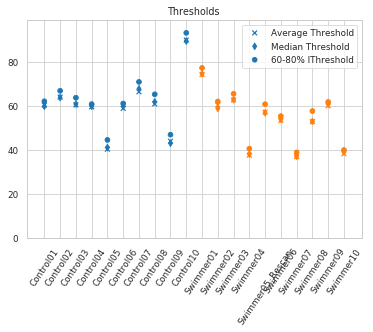

In [70]:
# Display the different thresholds
plt.scatter(x=Data.Sample, y=Data.ThresholdAverage, label='Average Threshold', c=Data.Color, marker='x')
plt.scatter(x=Data.Sample, y=Data.ThresholdMedian, label='Median Threshold', c=Data.Color, marker='d')
plt.scatter(x=Data.Sample, y=Data.Threshold6080, label='60-80% lThreshold', c=Data.Color)
plt.legend()
plt.ylim([0, Data.ThresholdAverage.max() * 1.1])
plt.xticks(rotation=90 * .618)
plt.title('Thresholds')
plt.show()

In [71]:
# # Show middle images with some data
# plt.rcParams['figure.figsize'] = (16, 5)
# for c, s in enumerate(SampleNames):
#     maximum = skimage.filters.rank.maximum(Data.MiddleSlice[c].astype('uint8'), skimage.morphology.disk(25))
#     plt.subplot(141)
#     plt.imshow(Data.MiddleSlice[c])
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.title('Middle slice of %s' % s)
#     plt.axis('off')
#     plt.subplot(142)
#     plt.imshow(Data.MiddleSlice[c], vmax=0.618 * numpy.max(Data.MiddleSlice[c]))
#     plt.imshow(maximum, cmap='viridis', alpha=0.5)
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.title('%s\nwith local maxima' % os.path.basename(Data.MiddleSliceName[c]))
#     plt.axis('off')
#     plt.subplot(143)
#     plt.hist(Data.MiddleSlice[c].ravel(), bins=32, log=True, color=Data.Color[c])
#     plt.axvline(Data.Threshold6080[c],
#                 label='60-80%% Threshold: %0.2f' % Data.Threshold6080[c],
#                 c=seaborn.color_palette()[2])
#     plt.axvline(Data.ThresholdAverage[c], label='Threshold Average: %0.2f' % Data.ThresholdAverage[c],
#                 c=seaborn.color_palette()[3])
#     plt.legend(loc='best')
#     plt.xlim([0, 255])
#     plt.title('Histogram of middle slice')
#     plt.subplot(144)
#     plt.imshow(MIPs[c])
#     plt.title('MIP of %s slices of %s' % (len(Data.SubsetNames[c]),
#                                           Data.Sample[c]))
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.savefig(os.path.join(OutPutDir, 'Details_%s.png' % Data.Sample[c]))
#     plt.show()
# plt.rcParams['figure.figsize'] = (16, 9)

In [72]:
def calculate_area_gills(image, threshold=None):
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    area_gills = numpy.sum(thresholded_image)
    return(area_gills)

In [73]:
# Calculate the gill area (pythonic way, but without saving it in the middle...)
# Data['AreaGills'] = [[calculate_area_gills(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [74]:
# Calculate the gill area (slow way, but with saving it in the middle...)
Data['OutputNameAreaGills'] = [os.path.join(f,
                                            sample + '_area_gills_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaGills'] = [numpy.nan for file in Data.OutputNameAreaGills]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaGills[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaGills[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating gill area on %s of %s VOI images' % (c + 1,
                                                                              len(Data.Sample),
                                                                              Data.Sample[c],
                                                                              len(Data.SubsetNames[c]),
                                                                              len(Data.VOINames[c])))
        Data.AreaGills[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            Data.AreaGills[c][d] = calculate_area_gills(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaGills[c][len(RootFolder):]))
        numpy.save(Data.OutputNameAreaGills[c], Data.AreaGills[c], allow_pickle=False)
        Data.AreaGills[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_area_gills_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_area_gills_from_3062_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_area_gills_from_3062_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_area_gills_from_2452_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_area_gills_from_2642_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_area_gills_from_3389_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_area_gills_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_area_gills_from_2400_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_area_gills_from_2572_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_area_gills

In [75]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [76]:
# Save gills images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.join(os.path.dirname(sample.OutputNameVOI), 'VOI_thresholded_gills')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s thresholded images to %s' % (c + 1,
                                                                           len(Data),
                                                                           sample.Sample,
                                                                           sample.NumberOfAnalyzedVOISlices,
                                                                           sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s thresholded images to the disk' % (c + 1,
                                                                          len(Data),
                                                                          Data.Sample[c],
                                                                          sample.NumberOfAnalyzedVOISlices))
        for d, i in enumerate(VOISubset[c]):
            t = i > Data.Threshold[c][d]
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_thresholded_gills_%04d.png' % d), t.astype('uint8') * 255)

 1/20: Control01: Already saved 2338 thresholded images to /Control01/VOI_thresholded_gills
 2/20: Control02: Already saved 3062 thresholded images to /Control02/VOI_thresholded_gills
 3/20: Control03: Already saved 3062 thresholded images to /Control03/VOI_thresholded_gills
 4/20: Control04: Already saved 2452 thresholded images to /Control04/VOI_thresholded_gills
 5/20: Control05: Already saved 2642 thresholded images to /Control05/VOI_thresholded_gills
 6/20: Control06: Already saved 3389 thresholded images to /Control06/VOI_thresholded_gills
 7/20: Control07: Already saved 2452 thresholded images to /Control07/VOI_thresholded_gills
 8/20: Control08: Already saved 2400 thresholded images to /Control08/VOI_thresholded_gills
 9/20: Control09: Already saved 2572 thresholded images to /Control09/VOI_thresholded_gills
10/20: Control10: Already saved 2452 thresholded images to /Control10/VOI_thresholded_gills
11/20: Swimmer01: Already saved 3062 thresholded images to /Swimmer01/VOI_thresh

In [77]:
def calculate_area_organ(image, threshold=None, verbose=False):
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    binary_closing = True
    if binary_closing:
        # Use simple binary closing
        closed = skimage.morphology.binary_closing(thresholded_image, selem=skimage.morphology.selem.disk(25))
    else:
        # Close small holes (this could be a bit more robust than simple binary closing)
        imagearea = numpy.shape(image)[0] * numpy.shape(image)[1]
        closed = skimage.morphology.remove_small_holes(thresholded_image, area_threshold=imagearea * 0.618)
    if verbose:
        # mask out Deas ROI
        masked = numpy.ma.masked_equal(image, 0)
        # Show the images
        plt.subplot(131)
        plt.imshow(masked.filled(0))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(thresholded_image)
        plt.axis('off')
        plt.title('Thresholded with %0.2f: %0.2g px' % (threshold, numpy.sum(thresholded_image)))
        plt.subplot(133)
        plt.imshow(closed)
        plt.axis('off')
        plt.title('Closed: %0.2g px' % numpy.sum(closed))
        plt.show()
    area_organ = numpy.sum(closed)
    return(area_organ)

In [78]:
# Calculate the (extrapolated) organ area (pythonic way, but without saving it in the middle...)
# Data['AreaOrgan'] = [[calculate_area_organ(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [79]:
# Calculate the (extrapolated) organ area (slow way, but with saving it in the middle...)
Data['OutputNameAreaOrgan'] = [os.path.join(f,
                                            sample + '_area_organ_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaOrgan'] = [numpy.nan for file in Data.OutputNameAreaOrgan]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaOrgan[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaOrgan[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating organ area on %s of %s VOI images' % (c + 1,
                                                                               len(Data.Sample),
                                                                               Data.Sample[c],
                                                                               len(Data.SubsetNames[c]),
                                                                               len(Data.VOINames[c])))
        Data.AreaOrgan[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            print('Working on image %04s of %04s' % (d, len(Data.SubsetNames[c])), end="\r")
            Data.AreaOrgan[c][d] = calculate_area_organ(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaOrgan[c][len(RootFolder):]))
        numpy.save(Data.OutputNameAreaOrgan[c], Data.AreaOrgan[c], allow_pickle=False)
        Data.AreaOrgan[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_area_organ_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_area_organ_from_3062_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_area_organ_from_3062_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_area_organ_from_2452_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_area_organ_from_2642_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_area_organ_from_3389_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_area_organ_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_area_organ_from_2400_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_area_organ_from_2572_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_area_organ

In [80]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [81]:
# Save organ area images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.join(os.path.dirname(sample.OutputNameVOI), 'VOI_organ_area')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s organ area images to %s' % (c + 1,
                                                                          len(Data),
                                                                          sample.Sample,
                                                                          sample.NumberOfAnalyzedVOISlices,
                                                                          sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s organ area images to the disk' % (c + 1,
                                                                         len(Data),
                                                                         Data.Sample[c],
                                                                         sample.NumberOfAnalyzedVOISlices))
        for d, i in enumerate(VOISubset[c]):
            thresholded = i > Data.Threshold[c][d]
            closed = skimage.morphology.binary_closing(thresholded, selem=skimage.morphology.selem.disk(25))
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_area_organ_%04d.png' % d), closed.astype('uint8') * 255)

 1/20: Control01: Already saved 2338 organ area images to /Control01/VOI_organ_area
 2/20: Control02: Already saved 3062 organ area images to /Control02/VOI_organ_area
 3/20: Control03: Already saved 3062 organ area images to /Control03/VOI_organ_area
 4/20: Control04: Already saved 2452 organ area images to /Control04/VOI_organ_area
 5/20: Control05: Already saved 2642 organ area images to /Control05/VOI_organ_area
 6/20: Control06: Already saved 3389 organ area images to /Control06/VOI_organ_area
 7/20: Control07: Already saved 2452 organ area images to /Control07/VOI_organ_area
 8/20: Control08: Already saved 2400 organ area images to /Control08/VOI_organ_area
 9/20: Control09: Already saved 2572 organ area images to /Control09/VOI_organ_area
10/20: Control10: Already saved 2452 organ area images to /Control10/VOI_organ_area
11/20: Swimmer01: Already saved 3062 organ area images to /Swimmer01/VOI_organ_area
12/20: Swimmer02: Already saved 2452 organ area images to /Swimmer02/VOI_org

In [82]:
Data['AreaGills'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaGills]
Data['AreaOrgan'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaOrgan]

In [83]:
# Sum the images to get the volume of the gills and organ
# This volume is obviously in voxels
Data['VolumeGills'] = [numpy.sum(ag) for ag in Data.AreaGills]
Data['VolumeOrgan'] = [numpy.sum(ao) for ao in Data.AreaOrgan]

In [84]:
# Calculate the volume in microliters
Data['VolumeGills_ul'] = [vg * vv for vg, vv in zip(Data.VolumeGills, Data.VoxelVolume)]
Data['VolumeOrgan_ul'] = [vo * vv for vo, vv in zip(Data.VolumeOrgan, Data.VoxelVolume)]

In [85]:
# Calculate the ratio of gills per organ
Data['GillsPerOrgan'] = [numpy.divide(ag, ao) for (ag, ao) in zip(Data['AreaGills'], Data['AreaOrgan'])]

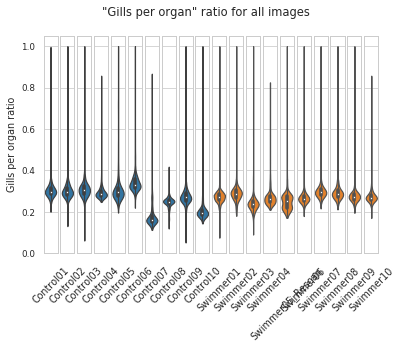

In [86]:
# Boxplots of the Areas
for c, a in enumerate(Data.GillsPerOrgan):
    plt.subplot(1, len(Data), c + 1)
    seaborn.violinplot(a, orient='v', color=Data.Color[c], cut=0)
#     seaborn.stripplot(a, orient='v', jitter=True, linewidth=1, s=5, color=Data.Color[c], alpha=0.318)
    plt.ylim([0, 1.05])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Gills per organ ratio')
    plt.xlabel(Data.Sample[c], rotation=45)
plt.suptitle('"Gills per organ" ratio for all images')
plt.savefig(os.path.join(OutPutDir, 'Gills_per_organ_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [87]:
# Calculate the mean 'gills per organ' ratio
Data['Mean_Gill_Ratio'] = [float(numpy.nanmean(a)) for a in Data['GillsPerOrgan']]

----

Now that we have all the data let's display all that we need!
The plots below are the ones that are shown in the manuscript.

In [88]:
# Change color palette from the default
# seaborn.set_palette(seaborn.color_palette('viridis', 2))

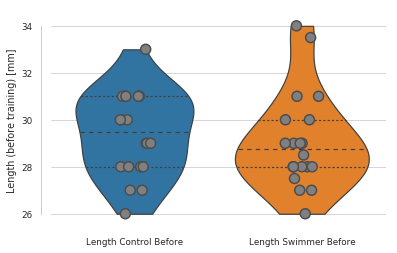

In [89]:
# Plot the fish length
seaborn.violinplot(data=Morphology[['Length Control Before',
                                    'Length Swimmer Before']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[['Length Control Before',
                                   'Length Swimmer Before']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Length (before training) [mm]')
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Lenghts-before.png'))
plt.show()

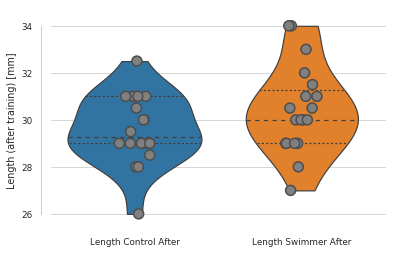

In [90]:
# Plot the fish length
seaborn.violinplot(data=Morphology[['Length Control After',
                                    'Length Swimmer After']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[['Length Control After',
                                   'Length Swimmer After']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Length (after training) [mm]')
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Lenghts-after.png'))
plt.show()

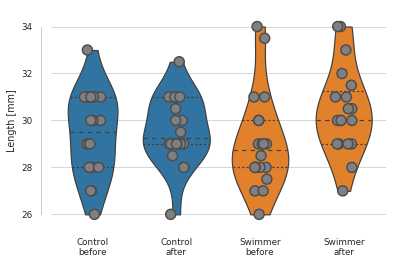

In [91]:
# Plot the fish length
seaborn.violinplot(data=Morphology[['Length Control Before', 'Length Control After',
                                    'Length Swimmer Before', 'Length Swimmer After']],
                   palette=(seaborn.color_palette()[0],
                          seaborn.color_palette()[0],
                          seaborn.color_palette()[1],
                          seaborn.color_palette()[1]),
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[['Length Control Before', 'Length Control After',
                                    'Length Swimmer Before', 'Length Swimmer After']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Length [mm]')
plt.gca().set_xticklabels(['Control\nbefore','Control\nafter','Swimmer\nbefore','Swimmer\nafter'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Lenghts.png'))
plt.show()

In [92]:
# Data as prose
print('The length of the control group before training was %0.2f mm with a STD of %0.2f.' % (Morphology['Length Control Before'].mean(),
                                                                                             Morphology['Length Control Before'].std()))
print('The length of the control group after training was %0.2f mm with a STD of %0.2f.' % (Morphology['Length Control After'].mean(),
                                                                                            Morphology['Length Control After'].std()))
print('The length of the swimmer group before training was %0.2f mm with a STD of %0.2f.' % (Morphology['Length Swimmer Before'].mean(),
                                                                                             Morphology['Length Swimmer Before'].std()))
print('The length of the swimmer group after training was %0.2f mm with a STD of %0.2f.' % (Morphology['Length Swimmer After'].mean(),
                                                                                            Morphology['Length Swimmer After'].std()))

The length of the control group before training was 29.40 mm with a STD of 1.79.
The length of the control group after training was 29.60 mm with a STD of 1.47.
The length of the swimmer group before training was 29.07 mm with a STD of 2.05.
The length of the swimmer group after training was 30.45 mm with a STD of 1.87.


In [93]:
print('The length of the controls increased by %0.2f %%' % percentage(Morphology['Length Control Before'].mean(),
                                                                      Morphology['Length Control After'].mean()))

The length of the controls increased by 0.68 %


In [94]:
print('The length of the swimmers increased by %0.2f %%' % percentage(Morphology['Length Swimmer Before'].mean(),
                                                                      Morphology['Length Swimmer After'].mean()))

The length of the swimmers increased by 4.72 %


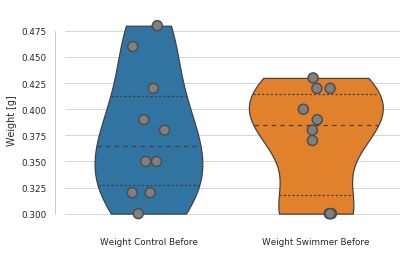

In [95]:
# Plot the fish weight
# But only for the males, since the females carry eggs or not
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control Before',
                                                                 'Weight Swimmer Before']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control Before',
                                                                'Weight Swimmer Before']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Weight [g]')
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Weights-before.png'))
plt.show()

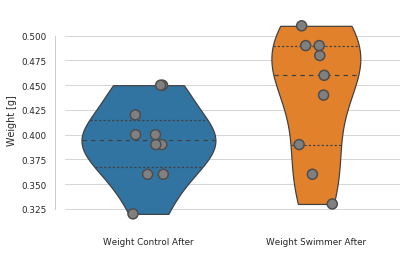

In [96]:
# Plot the fish weight
# But only for the males, since the females carry eggs or not
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control After',
                                                                 'Weight Swimmer After']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control After',
                                                                'Weight Swimmer After']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Weight [g]')
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Weights-after.png'))
plt.show()

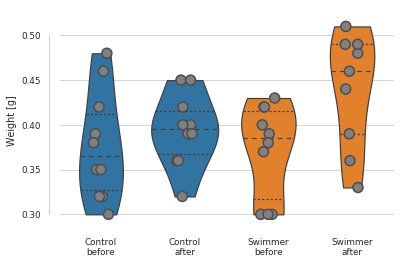

In [97]:
# Plot the fish weight
# But only for the males, since the females carry eggs or not
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control Before',
                                                                 'Weight Control After',
                                                                 'Weight Swimmer Before',
                                                                 'Weight Swimmer After']],
                   palette=(seaborn.color_palette()[0],
                            seaborn.color_palette()[0],
                            seaborn.color_palette()[1],
                            seaborn.color_palette()[1]),
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control Before',
                                                                'Weight Control After',
                                                                'Weight Swimmer Before',
                                                                'Weight Swimmer After']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Weight [g]')
plt.gca().set_xticklabels(['Control\nbefore','Control\nafter','Swimmer\nbefore','Swimmer\nafter'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Weights.png'))
plt.show()

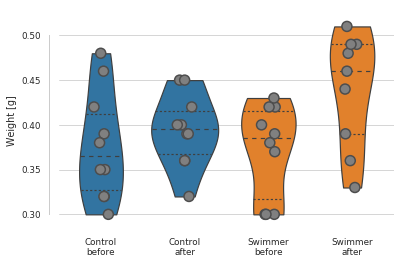

In [98]:
# Plot the fish weight
# But only for the males, since the females carry eggs or not
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control Before',
                                                                 'Weight Control After',
                                                                 'Weight Swimmer Before',
                                                                 'Weight Swimmer After']],
                   palette=(seaborn.color_palette()[0],
                            seaborn.color_palette()[0],
                            seaborn.color_palette()[1],
                            seaborn.color_palette()[1]),
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'][['Weight Control Before',
                                                                'Weight Control After',
                                                                'Weight Swimmer Before',
                                                                'Weight Swimmer After']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Weight [g]')
plt.gca().set_xticklabels(['Control\nbefore','Control\nafter','Swimmer\nbefore','Swimmer\nafter'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Weights.png'))
plt.show()

In [99]:
# Data as prose
print('The weight of the male control group before training was %0.3f g with a STD of %0.2f.' % (Morphology[Morphology.Gender == 'Male']['Weight Control Before'].mean(),
                                                                                            Morphology[Morphology.Gender == 'Male']['Weight Control Before'].std()))
print('The weight of the male control group after training was %0.3f g with a STD of %0.2f.' % (Morphology[Morphology.Gender == 'Male']['Weight Control After'].mean(),
                                                                                           Morphology[Morphology.Gender == 'Male']['Weight Control After'].std()))
print('The weight of the male swimmer group before training was %0.3f g with a STD of %0.2f.' % (Morphology[Morphology.Gender == 'Male']['Weight Swimmer Before'].mean(),
                                                                                            Morphology[Morphology.Gender == 'Male']['Weight Swimmer Before'].std()))
print('The weight of the male swimmer group after training was %0.3f g with a STD of %0.2f.' % (Morphology[Morphology.Gender == 'Male']['Weight Swimmer After'].mean(),
                                                                                           Morphology[Morphology.Gender == 'Male']['Weight Swimmer After'].std()))

The weight of the male control group before training was 0.377 g with a STD of 0.06.
The weight of the male control group after training was 0.394 g with a STD of 0.04.
The weight of the male swimmer group before training was 0.371 g with a STD of 0.05.
The weight of the male swimmer group after training was 0.439 g with a STD of 0.06.


In [100]:
print('The weight of the controls increased by %0.2f %%' % percentage(Morphology[Morphology.Gender == 'Male']['Weight Control Before'].mean(),
                                                                      Morphology[Morphology.Gender == 'Male']['Weight Control After'].mean()))

The weight of the controls increased by 4.51 %


In [101]:
print('The weight of the swimmers increased by %0.2f %%' % percentage(Morphology[Morphology.Gender == 'Male']['Weight Swimmer Before'].mean(),
                                                                      Morphology[Morphology.Gender == 'Male']['Weight Swimmer After'].mean()))

The weight of the swimmers increased by 18.30 %


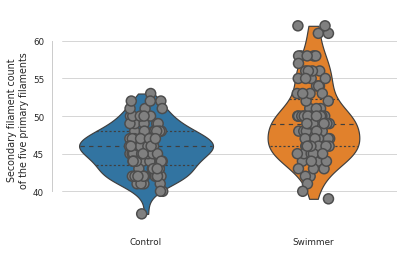

In [102]:
# Display filament count
seaborn.violinplot(data=Filaments[['Control Count', 'Swimmer Count']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Count', 'Swimmer Count']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel('Secondary filament count\nof the five primary filaments')
plt.gca().set_xticklabels(['Control','Swimmer'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Filament_count.png'))
plt.show()

In [103]:
print('The mean secondary filament count for the control group was %0.2f with a STD of %0.2f.' % (Filaments['Control Count'].mean(),
                                                                                                  Filaments['Control Count'].std()))
print('The mean secondary filament count for the swimmers group was %0.2f with a STD of %0.2f.' % (Filaments['Swimmer Count'].mean(),
                                                                                                   Filaments['Swimmer Count'].std()))
print('This is an increase of %0.2f %%' % percentage(Filaments['Control Count'].mean(), Filaments['Swimmer Count'].mean()))

The mean secondary filament count for the control group was 45.73 with a STD of 3.13.
The mean secondary filament count for the swimmers group was 49.27 with a STD of 5.02.
This is an increase of 7.75 %


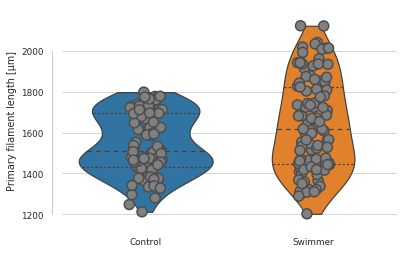

In [104]:
# Display filament length
seaborn.violinplot(data=Filaments[['Control Length', 'Swimmer Length']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Length', 'Swimmer Length']],
                  s=10, linewidth=1.5, color='gray')
plt.ylabel(u'Primary filament length [\u03bcm]')
plt.gca().set_xticklabels(['Control','Swimmer'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Filament_lenght.png'))
plt.show()

In [105]:
print('The mean filament length for the control was %0.f um with a STD of %0.f.' % (Filaments['Control Length'].mean(),
                                                                                    Filaments['Control Length'].std()))
print('The mean filament length for the swimmers was %0.f um with a STD of %0.f.' % (Filaments['Swimmer Length'].mean(),
                                                                                     Filaments['Swimmer Length'].std()))
print('This is an increase of %0.2f %%' % percentage(Filaments['Control Length'].mean(), Filaments['Swimmer Length'].mean()))

The mean filament length for the control was 1545 um with a STD of 148.
The mean filament length for the swimmers was 1639 um with a STD of 228.
This is an increase of 6.06 %


In [106]:
# # Display the respirometry data
# # Boxplot O2 normalized at start
# seaborn.boxplot(data=Data, x='Experiment', y='O2 consumption start normalized')
# seaborn.swarmplot(data=Data, x='Experiment', y='O2 consumption start normalized', s=10, linewidth=1.5)
# label = False
# if label:
#     shift = 0.05
#     for c, row in Data.iterrows():
#         if Data.Experiment[c] == 'Control':
#             plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
#                                                 Data['O2 consumption start normalized'][c]),
#                                horizontalalignment='left', verticalalignment='bottom')
#         else:
#             plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
#                                                 Data['O2 consumption start normalized'][c]),
#                                horizontalalignment='left', verticalalignment='bottom')
# plt.ylabel('$O_{2}$ consumption normalized to fish length')
# plt.title(('$O_{2}$ consumption at start of experiment'))
# plt.ylim([0.015, 0.06])
# if label:
#     plt.savefig(os.path.join(OutPutDir, 'O2_start_normalized.png'))
# else:
#     plt.savefig(os.path.join(OutPutDir, 'O2_start_normalized_nolabel.png'))
# plt.show()

In [107]:
# # Display the respirometry data
# # Boxplot O2 normalized at end
# seaborn.boxplot(data=Data, x='Experiment', y='O2 consumption end normalized')
# seaborn.swarmplot(data=Data, x='Experiment', y='O2 consumption end normalized', s=10, linewidth=1.5)
# label = False
# if label:
#     shift = 0.05
#     for c, row in Data.iterrows():
#         if Data.Experiment[c] == 'Control':
#             plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
#                                                 Data['O2 consumption end normalized'][c]),
#                                horizontalalignment='left', verticalalignment='bottom')
#         else:
#             plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
#                                                 Data['O2 consumption end normalized'][c]),
#                                horizontalalignment='left', verticalalignment='bottom')
# plt.ylabel('$O_{2}$ consumption normalized to fish length')
# plt.title(('$O_{2}$ consumption at end of experiment'))
# plt.ylim([0.015, 0.06])
# if label:
#     plt.savefig(os.path.join(OutPutDir, 'O2_end_normalized.png'))
# else:
#     plt.savefig(os.path.join(OutPutDir, 'O2_end_normalized_nolabel.png'))
# plt.show()

In [108]:
# Massage the respirometry data into a new dataframe for displaying it nicely
# On some respirometry data we have NaN.
# Let's fill this with 9999, so that we can merge the before/after data
Data['O2 consumption end normalized'][numpy.isnan(Data['O2 consumption end normalized'])] = 9999
respirometry = pandas.concat([Data[['Sample', 'Experiment', 'O2 consumption start normalized']],
                              Data[['Sample', 'Experiment', 'O2 consumption end normalized']]])
# Let's put NaN back
Data['O2 consumption end normalized'][Data['O2 consumption end normalized'] == 9999] = numpy.nan
# Merge, based on https://stackoverflow.com/a/10972557/323100
respirometry['o2'] = pandas.concat([respirometry['O2 consumption start normalized'].dropna(),
                                    respirometry['O2 consumption end normalized'].dropna()]).reindex_like(respirometry)
# Make us an experiment state, so we can 'hue' on this
respirometry['Training'] = ['Before' if o > 0 else 'After' for o in respirometry['O2 consumption start normalized']]
# Drop columns which we don't need
respirometry.drop(['O2 consumption end normalized',
                   'O2 consumption start normalized'], axis=1, inplace=True)
respirometry['o2'][respirometry['o2'] == 9999] = numpy.nan

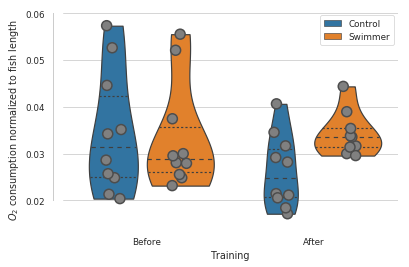

In [109]:
# Display respirometry data
seaborn.violinplot(data=respirometry, hue='Experiment', y='o2', x='Training', cut=0, inner='quartiles')
seaborn.stripplot(data=respirometry, hue='Experiment', y='o2', x='Training',
                  dodge=True, s=10, linewidth=1.5,
                  palette=['gray', 'gray'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
plt.ylabel('$O_{2}$ consumption normalized to fish length')
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'O2_normalized.png'))
plt.show()

In [110]:
print('The normalized O2 consumption for the control before '
      'training was %0.4f with a STD of %0.4f.' % (Data[Data.Experiment == 'Control']['O2 consumption start normalized'].mean(),
                                                   Data[Data.Experiment == 'Control']['O2 consumption start normalized'].std()))
print('The normalized O2 consumption for the swimmers before '
      'training was %0.4f with a STD of %0.4f.' % (Data[Data.Experiment == 'Swimmer']['O2 consumption start normalized'].mean(),
                                                   Data[Data.Experiment == 'Swimmer']['O2 consumption start normalized'].std()))
print('This is an increase of %0.2f %%' % percentage(Data[Data.Experiment == 'Control']['O2 consumption start normalized'].mean(),
                                                     Data[Data.Experiment == 'Swimmer']['O2 consumption start normalized'].mean()))

The normalized O2 consumption for the control before training was 0.0345 with a STD of 0.0130.
The normalized O2 consumption for the swimmers before training was 0.0334 with a STD of 0.0114.
This is an increase of -3.08 %


In [111]:
print('The normalized O2 consumption for the control after '
      'training was %0.4f with a STD of %0.4f.' % (Data[Data.Experiment == 'Control']['O2 consumption end normalized'].mean(),
                                                   Data[Data.Experiment == 'Control']['O2 consumption end normalized'].std()))
print('The normalized O2 consumption for the swimmers after '
      'training was %0.4f with a STD of %0.4f.' % (Data[Data.Experiment == 'Swimmer']['O2 consumption end normalized'].mean(),
                                                   Data[Data.Experiment == 'Swimmer']['O2 consumption end normalized'].std()))
print('This is an increase of %0.2f %%' % percentage(Data[Data.Experiment == 'Swimmer']['O2 consumption end normalized'].mean(),
                                                     Data[Data.Experiment == 'Control']['O2 consumption end normalized'].mean()))

The normalized O2 consumption for the control after training was 0.0263 with a STD of 0.0078.
The normalized O2 consumption for the swimmers after training was 0.0343 with a STD of 0.0048.
This is an increase of -23.31 %


In [112]:
print('Control start end: %0.2f %%' % percentage(Data[Data.Experiment == 'Control']['O2 consumption start normalized'].mean(),
                                                 Data[Data.Experiment == 'Control']['O2 consumption end normalized'].mean()))

Control start end: -23.72 %


In [113]:
print('Swimmer start end: %0.2f %%' % percentage(Data[Data.Experiment == 'Swimmer']['O2 consumption start normalized'].mean(),
                                                 Data[Data.Experiment == 'Swimmer']['O2 consumption end normalized'].mean()))

Swimmer start end: 2.63 %


Display the area mean (after we did some statistics)

In [114]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.Mean_Gill_Ratio)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9366322159767151, 0.20694465935230255)

In [115]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                   Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=3.384155056527279, pvalue=0.08237871281366123)

In [116]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                     Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio)
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.5, pvalue=0.11084033741322809)

In [117]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                                             Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio,
                                             equal_var=True)
print("The difference between the 'Mean_Gill_Ratio' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'Mean_Gill_Ratio' of 'Control' and 'Swimmer' has an
F value of 0.17 and a p value of 0.43.


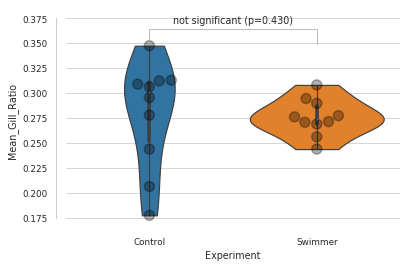

In [118]:
# Boxplot of the mean area for each animal (calculated slice-wise)
seaborn.violinplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', cut=0)
seaborn.swarmplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', s=10, linewidth=1.5,
                  color='k', alpha=0.309)
label = False
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Average "gills per organ" from slices')
plt.ylim(ymax=Data.Mean_Gill_Ratio.max() * 1.1)
# statistical annotation, see vottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, Data.Mean_Gill_Ratio.max()),
                   xycoords='data',
                   xytext=(1, Data.Mean_Gill_Ratio.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='#aaaaaa', connectionstyle="bar, fraction=0.1"))
plt.gca().text(0.5,
               Data.Mean_Gill_Ratio.max() + abs(Data.Mean_Gill_Ratio.max() - Data.Mean_Gill_Ratio.min()) * 0.15,
               significance(p_value / 2),
               horizontalalignment='center',
               verticalalignment='center')
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir,
                             'Gills_per_organ_average_slices_from%04dslices.png' % NumberOfImagesToShow))
else:
    plt.savefig(os.path.join(OutPutDir,
                             'Gills_per_organ_average_slices_from%04dslices_nolabels.png' % NumberOfImagesToShow))
plt.show()

Display the volume data (after we did some statistics)

In [119]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGills)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9144847393035889, 0.07763797044754028)

In [120]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.5468692212197214, pvalue=0.46913511203835245)

In [121]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.4, pvalue=0.3128526760169558)

In [122]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGills,
                                             equal_var=True)
print("The difference between the 'gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'gill volume' of 'Control' and 'Swimmer' has an
F value of -1.9 and a p value of 0.032.


In [123]:
# # Boxplot of the gills volume for each animal (in voxels)
# bars = seaborn.boxplot(data=Data, x='Experiment', y='VolumeGills')
# seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGills', s=10, linewidth=1)
# label = False
# if label:
#     shift = 0.05
#     for c, row in Data.iterrows():
#         if Data.Experiment[c] == 'Control':
#             plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
#                                                 Data.VolumeGills[c]),
#                                horizontalalignment='left', verticalalignment='bottom')
#         else:
#             plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
#                                                 Data.VolumeGills[c]),
#                                horizontalalignment='left', verticalalignment='bottom')
# plt.ylabel('[voxels]')
# plt.ylim(ymax=Data.VolumeGills.max() * 1.2)
# # statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
# plt.gca().annotate('',
#                    xy=(0, Data.VolumeGills.max()),
#                    xycoords='data',
#                    xytext=(1, Data.VolumeGills.max()),
#                    textcoords='data',
#                    arrowprops=dict(arrowstyle="-", ec='#aaaaaa', connectionstyle="bar, fraction=0.1"))
# plt.gca().text(0.5,
#                Data.VolumeGills.max() + abs(Data.VolumeGills.max() - Data.VolumeGills.min()) * 0.15,
#                significance(p_value / 2),
#                horizontalalignment='center',
#                verticalalignment='center')
# plt.title('Gill volume')
# if label:
#     plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_from%04dslices.png' % NumberOfImagesToShow))
# else:
#     plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_from%04dslices_nolabel.png' % NumberOfImagesToShow))
# plt.show()

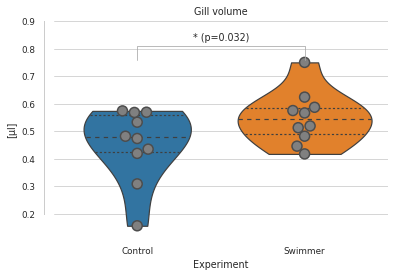

In [124]:
# Boxplot of the gills volume for each animal (in ul)
bars = seaborn.violinplot(data=Data, x='Experiment', y='VolumeGills_ul', cut=0, inner='quartiles')
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGills_ul', s=10, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.ylabel(u'[\u03bcl]')  # https://stackoverflow.com/a/2140991/323100
plt.ylim(ymax=Data.VolumeGills_ul.max() * 1.2)
# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, Data.VolumeGills_ul.max()),
                   xycoords='data',
                   xytext=(1, Data.VolumeGills_ul.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='#aaaaaa', connectionstyle="bar, fraction=0.1"))
plt.gca().text(0.5,
               Data.VolumeGills_ul.max() + abs(Data.VolumeGills_ul.max() - Data.VolumeGills_ul.min()) * 0.15,
               significance(p_value / 2),
               horizontalalignment='center',
               verticalalignment='center')
plt.title('Gill volume')
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_ul_from%04dslices.png' % NumberOfImagesToShow))
else:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_ul_from%04dslices_nolabel.png' % NumberOfImagesToShow))
plt.show()

In [125]:
# Print the mean volume of the gills
print('The "control" fishes have a mean gill volume of %0.3f ul'
      % Data[Data.Experiment == 'Control'].VolumeGills_ul.mean())
print('The "swimmer" fishes have a mean gill volume of %0.3f ul'
      % Data[Data.Experiment == 'Swimmer'].VolumeGills_ul.mean())

The "control" fishes have a mean gill volume of 0.453 ul
The "swimmer" fishes have a mean gill volume of 0.549 ul


Calculate the volume normalized to the fish length.

In [126]:
Data['VolumeGillsNormalized'] = [numpy.divide(gv, w) for gv, w in zip(Data.VolumeGills_ul, Data.Length)]

AttributeError: 'DataFrame' object has no attribute 'Length'

In [ ]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

In [ ]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

In [ ]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

In [ ]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                             equal_var=True)
print("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

In [ ]:
# Boxplot of the NORMALIZED gill volumes
seaborn.violinplot(data=Data, x='Experiment', y='VolumeGillsNormalized', cut=0)
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGillsNormalized', s=10, linewidth=1.5,
                  color='k', alpha=0.309)
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Normalized gill volume (normalized to fish length)')
plt.ylim(ymax=Data.VolumeGillsNormalized.max() * 1.2)
# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, Data.VolumeGillsNormalized.max()),
                   xycoords='data',
                   xytext=(1, Data.VolumeGillsNormalized.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='#aaaaaa', connectionstyle="bar, fraction=0.1"))
plt.gca().text(0.5,
               Data.VolumeGillsNormalized.max() + abs(Data.VolumeGillsNormalized.max() - Data.VolumeGillsNormalized.min()) * 0.15,
               significance(p_value / 2),
               horizontalalignment='center',
               verticalalignment='center')
plt.ylabel('ul/mm')
if label:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_ul_from%04dslices.png' % NumberOfImagesToShow))
else:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_ul_from%04slies_nolabels.png' % NumberOfImagesToShow))
plt.show()

In [ ]:
# Save data at the end
Data.to_csv('Data_%s.csv' % get_git_hash())
Data.to_csv(os.path.join(OutPutDir, 'Data_%s.csv' % get_git_hash()))

In [ ]:
print('All data has been saved to %s' % os.path.join(OutPutDir))

In [ ]:
print('Done!')